# Data Modeling 

### In this notebook, we move forward with our cleaned data and start our preprocessing and modeling 

How will you analyze the data to arrive at an initial approach?
How will you iterate on your initial approach to make it better?
What model type is most appropriate, given the data and the business problem?

In [155]:
#Importing the relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.count import CountEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# settings to display all columns
pd.set_option("display.max_columns", None)

In [156]:
df = pd.read_csv('data_cleaned_final.csv')

We can take a look again at our final cleaned dataset.

In [158]:
df.head()

,id,non_functional,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,lga,ward,population,scheme_management,permit,construction_year,extraction_type_class,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type_group
0,69572,0,6000.0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,Ludewa,Mundindi,109,VWC,Unknown,1999.0,gravity,user-group,pay annually,good,enough,spring,groundwater,communal standpipe
1,8776,0,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,Serengeti,Natta,280,Other,True,2010.0,gravity,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe
2,34310,0,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Manyara,Simanjiro,Ngorika,250,VWC,True,2009.0,gravity,user-group,pay per bucket,good,enough,dam,surface,communal standpipe
3,67743,1,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,Nanyumbu,Nanyumbu,58,VWC,True,1986.0,submersible,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe
4,19728,0,0.0,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,Karagwe,Nyakasimbi,0,Unknown,True,NaN,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe


## Modeling 

Because of the large number of categorical features in our dataset, we will choose model types that have high functionality with categories. 



First we start with selecting our X and y

In [102]:
X = df.drop(columns='non_functional')
y = df['non_functional']

For preprocessing purposes, we have to split our features into three different groups. One group holds our numerica data. The next deals with categorical columns that have less than 25 unique vales. FInally, out last column deals with any categorical columns that have 25 or more unique values. 

In [159]:
#Lists to hold column names
num_cols = []
sm_cat_cols = []
lg_cat_cols = []

for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 25:
        sm_cat_cols.append(c)
    else:
        lg_cat_cols.append(c)

Our deliverable to our stakeholders is the final model. With this in consideration, we decided to separate off a holdout set of values before modeling to use on our best model. After this first separation we proceed with a traditional train test split.

In [104]:
#First holdout set
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y,
                                                          test_size = .10, random_state = 396)
#Performing train test split on the remaining data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size = .25, random_state = 396)

In [106]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, cv=5, grid_search=False):
    '''
Function takes in evaluator, training data, and test data and returns the accuracy, precision, recall, f1, 
and the ROC-AUC scores for the model.  If ‘cv’ parameter is set to “True”,  
the function will perform cross-evaluation on model. 
If ‘cv’ parameter is set to “True” then a confusion matrix plot will not be generated. 

Based off of Lindsey Berlin’s evaluate function found at: 
https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb
------------------------------------------------------------------------------------------
Inputs: 
-Estimator - Estimator object  
-X_tr – X_train dataframe
-X_te – X_test dataframe
-Y_tr – y_train dataframe
-Y_te – y_test dataframe
-Cross_val – Boolean value indicating whether to perform cross validation using the estimator, defaults to True
-Cv – If cross_val  set to true this determines the cross-validation splitting strategy.  Takes in all value options for sklearn.model_selection_cross_val_score “cv” parameter:
        -None, to use the default 5-fold cross validation,
        -int, to specify the number of folds in a (Stratified)KFold,
        -CV splitter,
        -An iterable yielding (train, test) splits as arrays of indices

Returns – nothing is returned 

    '''
    if grid_search == False:
        # Cross-Validate
        output = cross_validate(estimator, X_tr, y_tr, cv=cv,
                                scoring=['accuracy', 'precision','recall', 'f1', 'roc_auc'])
        print('Results of Cross-Validation:\n')
        print(f'Average accuracy: {output["test_accuracy"].mean()}\
        +/- {output["test_accuracy"].std()}')
        print(f'Average precision: {output["test_precision"].mean()}\
        +/- {output["test_precision"].std()}')
        print(f'**Average recall: {output["test_recall"].mean()}\
        +/- {output["test_recall"].std()}')
        print(f'Average f1 score: {output["test_f1"].mean()}\
        +/- {output["test_f1"].std()}')
        print(f'Average roc_auc: {output["test_roc_auc"].mean()}\
        +/- {output["test_roc_auc"].std()}\n')
        print('+'*20)
    
        # Test Validate
        estimator.fit(X_tr, y_tr)
        tr_preds = estimator.predict(X_tr)
        te_preds = estimator.predict(X_te)
        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')
        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')
        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")
        print("<>"*10)
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"**Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")
    
    else:
        estimator.fit(X_tr, y_tr)
        tr_preds = estimator.predict(X_tr)
        te_preds = estimator.predict(X_te)
        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')
        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')
        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")
        print("<>"*10)
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"**Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")

### Preprocessing

**NUMERIC COLUMNS**

- (Prob not) Create new t/f columns for construction year and population
- IterativeImputer
    - construction year - 0 doesn't make sense -> nan
    - lat/long 'hidden nans' 
- MinMaxScaler - doesn't assume normal distribution

**CATEGORICAL COLUMNS**
- "Unknown" becomes separate category
- OHE for small
- CountEncoder for large¶



Our first step in our modeling process is to set up some pipelines to deal with our data. 

In [107]:
# creating Pipelines for each column type:
# numeric, categorical with under 25 categories, categorical with over 25 categories

num_col_pipe = Pipeline(steps = [
    ('ii', IterativeImputer(random_state=396, add_indicator=True)),
    ('mm', MinMaxScaler())
])

sm_cat_col_pipe = Pipeline(steps = [
    ('ohe', OneHotEncoder(handle_unknown = 'indicator'))
])

lg_cat_col_pipe = Pipeline(steps = [
    ('count', CountEncoder(min_group_size=10, min_group_name='Other'))
])

all_cat_col_pipe = Pipeline(steps = [
    ('catboost', CatBoostEncoder(random_state=396))
])

In [108]:
preprocessor1 = ColumnTransformer(transformers=[
    ('numeric', num_col_pipe, num_cols),
    ('small_cat', sm_cat_col_pipe, sm_cat_cols),
    ('large_cat', lg_cat_col_pipe, lg_cat_cols )
])

preprocessor2 = ColumnTransformer(transformers=[
    ('numeric', num_col_pipe, num_cols),
    ('cat', all_cat_col_pipe, [*sm_cat_cols, *lg_cat_cols]),
])

## Stupid Dummy Idiot Model

C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn

Results of Cross-Validation:

Average accuracy: 0.5431494883953081        +/- 4.9912652857475586e-05
Average precision: 0.0        +/- 0.0
**Average recall: 0.0        +/- 0.0
Average f1 score: 0.0        +/- 0.0
Average roc_auc: 0.5        +/- 0.0

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.5431494883953082
Train precision: 0.0
**Train recall: 0.0
Train f1 score: 0.0
Train roc_auc: 0.5

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.5414389458710789
Test precision: 0.0
**Test recall: 0.0
Test f1 score: 0.0
Test roc_auc: 0.5


C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


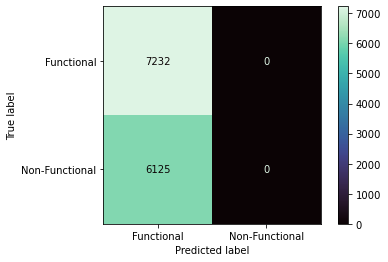

In [109]:
dumbdumbdumb = logreg = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

evaluate(dumbdumbdumb, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.7415273271774394        +/- 0.003431472196308592
Average precision: 0.7825199949751209        +/- 0.005480220895394305
**Average recall: 0.6013872738032707        +/- 0.004677557418871714
Average f1 score: 0.6800896861477266        +/- 0.004334142966588388
Average roc_auc: 0.8134909862383065        +/- 0.005338088336358814

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.740379336161717
Train precision: 0.7823911955977989
**Train recall: 0.5980552824210641
Train f1 score: 0.6779157249450447
Train roc_auc: 0.7290726696979425

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7359436999326197
Test precision: 0.7772087067861716
**Test recall: 0.5946122448979592
Test f1 score: 0.6737582092313386
Test roc_auc: 0.7251269189091566


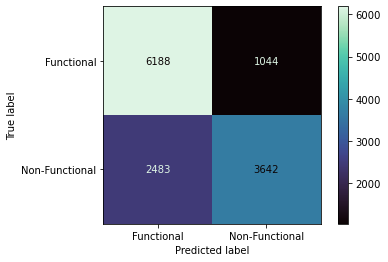

In [110]:
# ~2 minutes
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', LogisticRegression(random_state=396, max_iter=1000))
])

evaluate(logreg, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.757025205889693        +/- 0.004205270596414361
Average precision: 0.7306503483158818        +/- 0.006045429633321334
**Average recall: 0.7416146039311139        +/- 0.006498050925369052
Average f1 score: 0.7360643759690839        +/- 0.0043672121274495315
Average roc_auc: 0.7558008377370329        +/- 0.004118197665999735

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7545856105412893
Test precision: 0.7305263157894737
**Test recall: 0.7364897959183674
Test f1 score: 0.7334959349593496
Test roc_auc: 0.7532006501715731


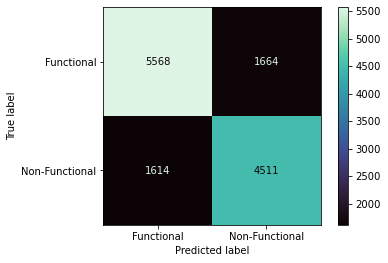

In [111]:
dt = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', DecisionTreeClassifier(random_state=396))
])

evaluate(dt, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.8152732717743948        +/- 0.0023299106597422107
Average precision: 0.82439132524158        +/- 0.0042771856420080285
**Average recall: 0.7569648997783329        +/- 0.009397070290811993
Average f1 score: 0.7891869362345965        +/- 0.0038763126085326854
Average roc_auc: 0.8927354780665431        +/- 0.0026139743500277843

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8213670734446358
Test precision: 0.831648039737449
**Test recall: 0.7653877551020408
Test f1 score: 0.797143342968883
Test roc_auc: 0.8170827049846489


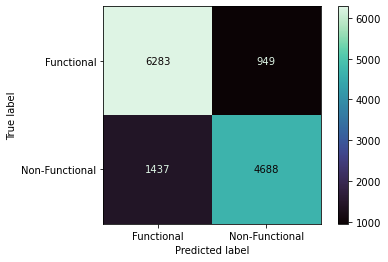

In [112]:
rf1 = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', RandomForestClassifier(random_state=396))
])

evaluate(rf1, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.7979785375592714        +/- 0.002804673640546303
Average precision: 0.8174167934834685        +/- 0.003822635296663712
**Average recall: 0.7182344314158523        +/- 0.004207145368195593
Average f1 score: 0.7646159482454393        +/- 0.003397808422977967
Average roc_auc: 0.8758848972817003        +/- 0.003410831681977849

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.8566259046668331
Train precision: 0.8849053134767421
**Train recall: 0.7887577843330056
Train f1 score: 0.83406983796898
Train roc_auc: 0.8512342496375559

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8028748970577225
Test precision: 0.8235730170496665
**Test recall: 0.7255510204081632
Test f1 score: 0.7714608106935162
Test roc_auc: 0.7969569261332852


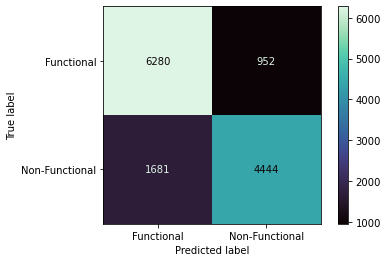

In [113]:
# using CatBoost Encoding
# ~
rf2 = Pipeline(steps=[
    ('preprocessor2', preprocessor2),
    ('classifier', RandomForestClassifier(random_state=396))
])

evaluate(rf2, X_train, X_test, y_train, y_test, cv=5)

In [114]:
abdt = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                                      random_state=396))
])



In [115]:
grid = {'n_estimators': [10,20,30,50,100,200,300,400,500,1000,1500],
        'learning_rate': [.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0,1.5,2.0]
    }

In [116]:
abdt = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', GridSearchCV(estimator=AdaBoostClassifier(), param_grid = grid, verbose = 4))
])

In [ ]:
gs_pipe = GridSearchCV(estimator=test_model_loop, param_grid=x['params'])
gs_pipe.fit(X,y)
print('Best Params: {}'.format(gs_pipe.best_params_))
print('Best Score: {}'.format(gs_pipe.best_score_))

Results of Cross-Validation:

Average accuracy: 0.7636136760668828        +/- 0.0030448763774888056
Average precision: 0.8278196378339084        +/- 0.003975316848702932
**Average recall: 0.6093620730474032        +/- 0.009875412739295259
Average f1 score: 0.7019254928360223        +/- 0.0058993093766013015
Average roc_auc: 0.8427338851299018        +/- 0.0027408639534880243

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7663339156476167
Train precision: 0.8334203265975691
**Train recall: 0.610564842128264
Train f1 score: 0.7047955355172305
Train roc_auc: 0.7539591349034998

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7629707269596466
Test precision: 0.8297303320704257
**Test recall: 0.6078367346938776
Test f1 score: 0.7016584998115342
Test roc_auc: 0.7510975708867618


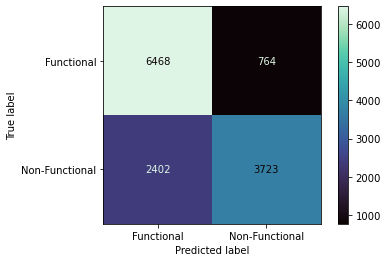

In [117]:
gbc = Pipeline(steps=[
    ('preprocessor1', preprocessor1),
    ('classifier', GradientBoostingClassifier())
])

evaluate(gbc, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.7636136760668828        +/- 0.0030448763774888056
Average precision: 0.8278196378339084        +/- 0.003975316848702932
**Average recall: 0.6093620730474032        +/- 0.009875412739295259
Average f1 score: 0.7019254928360223        +/- 0.0058993093766013015
Average roc_auc: 0.8427322160724156        +/- 0.0027385010290350994

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7663339156476167
Train precision: 0.8334203265975691
**Train recall: 0.610564842128264
Train f1 score: 0.7047955355172305
Train roc_auc: 0.7539591349034998

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7629707269596466
Test precision: 0.8297303320704257
**Test recall: 0.6078367346938776
Test f1 score: 0.7016584998115342
Test roc_auc: 0.7510975708867618


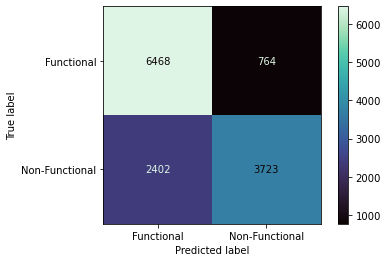

In [118]:
gbc2 = Pipeline(steps=[
    ('preprocessor1', preprocessor1),
    ('classifier', GradientBoostingClassifier(loss = 'exponential'))
])

evaluate(gbc, X_train, X_test, y_train, y_test, cv=5)

In [119]:
ada = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', AdaBoostClassifier())
])

In [120]:
rndfor = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', RandomForestClassifier(random_state=396))
])

In [121]:
X_train_fix = preprocessor1.fit_transform(X_train)

In [122]:
w_avg = VotingClassifier(estimators=[
    ('ada', ada),
    ('rndfor', rndfor)],
    weights=[0.25, 0.75], voting = 'soft')



In [123]:
w_avg.fit(X_test, y_test)

VotingClassifier(estimators=[('ada',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('numeric',
                                                                                Pipeline(steps=[('ii',
                                                                                                 IterativeImputer(add_indicator=True,
                                                                                                                  random_state=396)),
                                                                                                ('mm',
                                                                                                 MinMaxScaler())]),
                                                                                ['id',
                                                                                 'amount_tsh',
                                     

Results of Cross-Validation:

Average accuracy: 0.8150985774893936        +/- 0.002682543907518888
Average precision: 0.8227747359439732        +/- 0.004185907317656219
**Average recall: 0.7587676113121151        +/- 0.009549252654216177
Average f1 score: 0.7894244284090602        +/- 0.004210308386576149
Average roc_auc: 0.893114859110214        +/- 0.002597691013057002

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8209178707793666
Test precision: 0.8298285916239618
**Test recall: 0.7666938775510204
Test f1 score: 0.7970128988458927
Test roc_auc: 0.8167678458551563


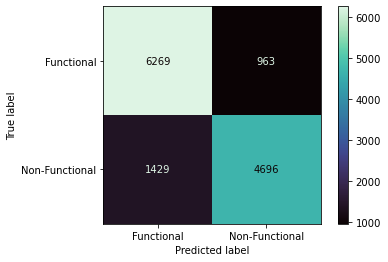

In [124]:
evaluate(w_avg, X_train, X_test, y_train, y_test, cv=5)

In [135]:
rndfor2 = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', RandomForestClassifier(random_state=396, class_weight='balanced', criterion='entropy', max_depth=20, n_estimators=1000))
])

In [136]:
X_train_fix = preprocessor1.fit_transform(X_train)

In [137]:
w_avg2 = VotingClassifier(estimators=[
    ('ada', ada),
    ('rndfor2', rndfor2)],
    weights=[0.20, 0.80], voting = 'soft')

In [138]:
w_avg2.fit(X_test, y_test)

VotingClassifier(estimators=[('ada',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('numeric',
                                                                                Pipeline(steps=[('ii',
                                                                                                 IterativeImputer(add_indicator=True,
                                                                                                                  random_state=396)),
                                                                                                ('mm',
                                                                                                 MinMaxScaler())]),
                                                                                ['id',
                                                                                 'amount_tsh',
                                     

Results of Cross-Validation:

Average accuracy: 0.8195657599201398        +/- 0.0032985806731768547
Average precision: 0.8370072768233386        +/- 0.003686886526927026
**Average recall: 0.7513927561849844        +/- 0.008383753887224418
Average f1 score: 0.7918612565394569        +/- 0.0046602141393743335
Average roc_auc: 0.8978746676562913        +/- 0.0019784534669153803

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.9514349887696532
Train precision: 0.9726684386917832
**Train recall: 0.9195345788266143
Train f1 score: 0.9453554981466922
Train roc_auc: 0.9489007207678375

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8201691996705847
Test precision: 0.8361928842333394
**Test recall: 0.7559183673469387
Test f1 score: 0.7940318984736752
Test roc_auc: 0.8152517721690447


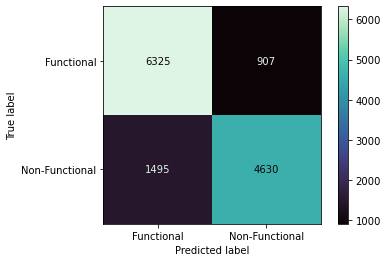

In [139]:
evaluate(w_avg2, X_train, X_test, y_train, y_test, cv=5)

In [140]:
sm_cat_cols

['basin',
 'region',
 'scheme_management',
 'permit',
 'extraction_type_class',
 'management_group',
 'payment',
 'quality_group',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type_group']

In [141]:
lg_cat_cols

['funder', 'installer', 'lga', 'ward']

In [142]:
num_cols

['id',
 'amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'population',
 'construction_year']

In [ ]:
test_dict = {'dec_tree':KNeighborsClassifier(), 'lr':LogisticRegression()}

def basic_model_tests(X, y, test_dict):
    '''Takes in X and y data as well as dictionary of name:test entries to run'''
    scores = []
    for key, value in test_dict.items():
        test_model_loop = Pipeline(steps=[
            (key, value)
        ])
        test_model_loop.fit(X, y)
        score = test_model_loop.score(X, y)
        scores.append({'name':key, 'type':value, 'score':score})
    return scores

In [ ]:
test_list = [{'name':'knn', 'type': KNeighborsClassifier(), 'params':{'knn__n_neighbors': [3, 5, 7], 'knn__p': [1, 2, 3]}},
            {'name': 'lr', 'type': LogisticRegression(), 'params':{'lr__fit_intercept':[False], 'lr__C':[1, 1000, 1e12],
                                                                  'lr__solver':['liblinear','newton-cg', 'lbfgs']}}]
#fit_intercept=False, C= 1e12, solver='liblinear'

In [ ]:
def model_tests(X, y, test_list):
    '''Takes in X and y data as well as a list of dictionaries'''
    scores = []
    for x in test_list:
        test_model_loop = Pipeline(steps=[
            (x['name'], x['type'])
        ])
        test_model_loop.fit(X, y)
#         score = test_model_loop.score(X, y)
#         scores.append({'name':x['name'], 'type':x['type'], 'score':score})
        
        gs_pipe = GridSearchCV(estimator=test_model_loop, param_grid=x['params'])
        gs_pipe.fit(X,y)
        scores.append(gs_pipe.cv_results_)
    return scores